In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
from scipy import io
import pickle
import cmocean
from salishsea_tools import Keegan_eval_tools as ket
import json
from collections import OrderedDict
from matplotlib.colors import LogNorm
import arrow
import glob
import datetime
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.dates import HourLocator, MonthLocator, YearLocator

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [3]:
yearList = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

data = 'month-avg.202111'
#year = '2014'
month = '01'
file = 'biol'

for year in yearList:
    files=[glob.glob(f'/results2/SalishSea/{data}/SalishSeaCast_1m_{file}_T_*{year}*{month:02d}01_*{year}*{month:02d}??.nc')[0] for year in yearList for month in range(1,13) ]
    

## Bring in grid coordinates for Juan de Fuca slice/box

In [4]:
JdF = [300,365, 50, 100]

In [5]:
## Gathering metadata but still not opening the files
JdFfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['ammonium', 'silicon', \
                        'dissolved_organic_nitrogen', \
                        'particulate_organic_nitrogen', 'biogenic_silicon'],
        parallel=True,
        engine='netcdf4'
    )

In [6]:
np.shape(JdF)

(4,)

In [7]:
np.shape(JdFfiles.time)

(192,)

In [8]:
np.shape(tmask) 

(40, 898, 398)

In [9]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [10]:
JdFmask=np.broadcast_to(tmask[:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]],(192,40,65,50))

In [11]:
np.shape(JdFmask) 

(192, 40, 65, 50)

## Bring in grid coordinates for Haro Strait slice/box

In [12]:
Haro = [280,320, 210, 250]

In [13]:
## Gathering metadata but still not opening the files
Harofiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['ammonium', 'silicon', \
                        'dissolved_organic_nitrogen', \
                        'particulate_organic_nitrogen', 'biogenic_silicon'],
        parallel=True,
        engine='netcdf4'
    )

In [14]:
np.shape(Haro)

(4,)

In [15]:
np.shape(Harofiles.time)

(192,)

In [16]:
np.shape(tmask) 

(40, 898, 398)

In [17]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [18]:
Haromask=np.broadcast_to(tmask[:,Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]],(192,40,40,40))

## Bring in grid coordinates for Puget Sound slice/box

In [19]:
Puget = [75,125, 225, 280]

In [20]:
## Gathering metadata but still not opening the files
Pugetfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['ammonium', 'silicon', \
                        'dissolved_organic_nitrogen', \
                        'particulate_organic_nitrogen', 'biogenic_silicon'],
        parallel=True,
        engine='netcdf4'
    )

In [21]:
np.shape(Puget)

(4,)

In [22]:
np.shape(Pugetfiles.time)

(192,)

In [23]:
np.shape(tmask) 

(40, 898, 398)

In [24]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [25]:
Pugetmask=np.broadcast_to(tmask[:,Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]],(192,40,50,55))

In [26]:
np.shape(Pugetmask) 

(192, 40, 50, 55)

## Bring in grid coordinates for Central SoG slice/box

In [27]:
CentralSoG = [450, 500,250,300]

In [28]:
## Gathering metadata but still not opening the files
CSOGfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['ammonium', 'silicon', \
                        'dissolved_organic_nitrogen', \
                        'particulate_organic_nitrogen', 'biogenic_silicon'],
        parallel=True,
        engine='netcdf4'
    )

In [29]:
np.shape(CentralSoG)

(4,)

In [30]:
np.shape(CSOGfiles.time)

(192,)

In [31]:
np.shape(tmask) 

(40, 898, 398)

In [32]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [33]:
CSOGmask=np.broadcast_to(tmask[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,40,50,50))

In [34]:
np.shape(CSOGmask) 

(192, 40, 50, 50)

## Bring in grid coordinates for Northern SoG slice/box

In [35]:
NorthernSoG = [650,700, 140,180]

In [36]:
## Gathering metadata but still not opening the files
NSOGfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['ammonium', 'silicon', \
                        'dissolved_organic_nitrogen', \
                        'particulate_organic_nitrogen', 'biogenic_silicon'],
        parallel=True,
        engine='netcdf4'
    )

In [37]:
np.shape(NorthernSoG)

(4,)

In [38]:
np.shape(NSOGfiles.time)

(192,)

In [39]:
np.shape(tmask) 

(40, 898, 398)

In [40]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [41]:
NSOGmask=np.broadcast_to(tmask[:,NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]],(192,40,50,40))

In [42]:
np.shape(NSOGmask) 

(192, 40, 50, 40)

In [43]:
class RegionDataExtractor:
    def __init__(self, regions, variables):
        self.regions = regions
        self.variables = variables
        self.data = {}

    def extract_all(self):
        for region_name, (files, mask, region_slice) in self.regions.items():
            self.data[region_name] = {}
            for var in self.variables:
                raw = getattr(files, var)[:, :, region_slice[0]:region_slice[1], region_slice[2]:region_slice[3]]
                arr = np.array(raw)
                masked = np.ma.masked_where(mask == 0, arr)
                self.data[region_name][var] = masked

    def get(self, region, variable):
        # get masked array for a specific region and variable
        return self.data[region][variable]

In [44]:
# Define regions
regions = {
    'JdF':  (JdFfiles, JdFmask, JdF),
    'Haro': (Harofiles, Haromask, Haro),
    'Puget': (Pugetfiles, Pugetmask, Puget),
    'NSOG': (NSOGfiles, NSOGmask, NorthernSoG),
    'CSOG': (CSOGfiles, CSOGmask, CentralSoG)
}

# Create a list of variables to extract
variables = ['diatoms', 'flagellates', 'microzooplankton', 'mesozooplankton']

# Create extractor
extractor = RegionDataExtractor(regions, variables)
extractor.extract_all()



In [45]:
# Get data for each variable from each region:
JdF_diatoms = extractor.get('JdF', 'diatoms').T ## transpose variables for hovmoller plotting
JdF_flag = extractor.get('JdF', 'flagellates').T 
JdF_Z1 = extractor.get('JdF', 'microzooplankton').T 
JdF_Z2 = extractor.get('JdF', 'mesozooplankton').T 

Haro_diatoms = extractor.get('Haro', 'diatoms').T ## transpose variables for hovmoller plotting
Haro_flag = extractor.get('Haro', 'flagellates').T 
Haro_Z1 = extractor.get('Haro', 'microzooplankton').T 
Haro_Z2 = extractor.get('Haro', 'mesozooplankton').T 

Puget_diatoms = extractor.get('Puget', 'diatoms').T ## transpose variables for hovmoller plotting
Puget_flag = extractor.get('Puget', 'flagellates').T 
Puget_Z1 = extractor.get('Puget', 'microzooplankton').T 
Puget_Z2 = extractor.get('Puget', 'mesozooplankton').T 

CSOG_diatoms = extractor.get('CSOG', 'diatoms').T ## transpose variables for hovmoller plotting
CSOG_flag = extractor.get('CSOG', 'flagellates').T 
CSOG_Z1 = extractor.get('CSOG', 'microzooplankton').T 
CSOG_Z2 = extractor.get('CSOG', 'mesozooplankton').T 

NSOG_diatoms = extractor.get('NSOG', 'diatoms').T ## transpose variables for hovmoller plotting
NSOG_flag = extractor.get('NSOG', 'flagellates').T 
NSOG_Z1 = extractor.get('NSOG', 'microzooplankton').T 
NSOG_Z2 = extractor.get('NSOG', 'mesozooplankton').T 


In [46]:
np.shape(JdF_diatoms)

(50, 65, 40, 192)

In [47]:
regions = ['JdF', 'Haro', 'Puget', 'CSOG', 'NSOG']
variables = ['diatoms', 'flagellates', 'microzooplankton', 'mesozooplankton']

# Extract and store transposed data
data = {
    (region, var): extractor.get(region, var).T
    for region in regions
    for var in variables
}

# Compute means across each region's box (axes 0 and 1)
means = {
    (region, var): np.mean(array, axis=(0, 1))
    for (region, var), array in data.items()
}

In [48]:
JdF_diatoms_mean = means[('JdF', 'diatoms')]
JdF_flag_mean = means[('JdF', 'flagellates')]
JdF_Z1_mean = means[('JdF', 'microzooplankton')]
JdF_Z2_mean = means[('JdF', 'mesozooplankton')]

Haro_diatoms_mean = means[('Haro', 'diatoms')]
Haro_flag_mean = means[('Haro', 'flagellates')]
Haro_Z1_mean = means[('Haro', 'microzooplankton')]
Haro_Z2_mean = means[('Haro', 'mesozooplankton')]

Puget_diatoms_mean = means[('Puget', 'diatoms')]
Puget_flag_mean = means[('Puget', 'flagellates')]
Puget_Z1_mean = means[('Puget', 'microzooplankton')]
Puget_Z2_mean = means[('Puget', 'mesozooplankton')]

CSOG_diatoms_mean = means[('CSOG', 'diatoms')]
CSOG_flag_mean = means[('CSOG', 'flagellates')]
CSOG_Z1_mean = means[('CSOG', 'microzooplankton')]
CSOG_Z2_mean = means[('CSOG', 'mesozooplankton')]

NSOG_diatoms_mean = means[('NSOG', 'diatoms')]
NSOG_flag_mean = means[('NSOG', 'flagellates')]
NSOG_Z1_mean = means[('NSOG', 'microzooplankton')]
NSOG_Z2_mean = means[('NSOG', 'mesozooplankton')]

## Dataset for climatology

In [49]:
clim=nc.Dataset('/results2/SalishSea/month-avg.202111/SalishSeaCast_month_climatology_biol_T_20070101_20230831.nc')

In [50]:
clim.variables.keys()

dict_keys(['nitrate', 'ammonium', 'silicon', 'diatoms', 'flagellates', 'microzooplankton', 'dissolved_organic_nitrogen', 'particulate_organic_nitrogen', 'biogenic_silicon', 'mesozooplankton', 'depth', 'gridY', 'gridX', 'month'])

#### Now I need to mask for the climatology in each region

In [51]:
JdFclimmask=np.broadcast_to(tmask[:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]],(12,40,65,50)) ## mask for climatology files

Haroclimmask=np.broadcast_to(tmask[:,Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]],(12,40,40,40)) ## mask for climatology files

Pugetclimmask=np.broadcast_to(tmask[:,Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]],(12,40,50,55)) ## mask for climatology files

CSOGclimmask=np.broadcast_to(tmask[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(12,40,50,50)) ## mask for climatology files

NSOGclimmask=np.broadcast_to(tmask[:,NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]],(12,40,50,40)) ## mask for climatology files

In [52]:
region_slices = {
    'JdF': JdF,
    'Haro': Haro,
    'Puget': Puget,
    'CSOG': CentralSoG,
    'NSOG': NorthernSoG
}

broadcast_shapes = {
    'JdF': (12, 40, 65, 50),
    'Haro': (12, 40, 40, 40),
    'Puget': (12, 40, 50, 55),
    'CSOG': (12, 40, 50, 50),
    'NSOG': (12, 40, 50, 40)
}

variables = ['diatoms', 'flagellates', 'microzooplankton','mesozooplankton']  # add others as needed

clim_masked = {}  # dict to hold masked outputs

for region, slc in region_slices.items():
    shape = broadcast_shapes[region]
    mask = np.broadcast_to(tmask[:, slc[0]:slc[1], slc[2]:slc[3]], shape)
    
    for var in variables:

        # Extract, slice, and mask the data
        data = clim[var][:, :, slc[0]:slc[1], slc[2]:slc[3]]
        masked = np.ma.masked_where(mask == 0, data)

        # Store using a tuple key (region, variable)
        clim_masked[(region, var)] = masked

In [53]:
JdFclim_diatoms=np.tile(np.mean(clim_masked[('JdF', 'diatoms')],axis=(2,3)),(16,1)).T ## take the mean across axes 2,3 then repeat for 16 years
JdFclim_flag=np.tile(np.mean(clim_masked[('JdF', 'flagellates')],axis=(2,3)),(16,1)).T
JdFclim_Z1=np.tile(np.mean(clim_masked[('JdF', 'microzooplankton')],axis=(2,3)),(16,1)).T
JdFclim_Z2=np.tile(np.mean(clim_masked[('JdF', 'mesozooplankton')],axis=(2,3)),(16,1)).T

Haroclim_diatoms=np.tile(np.mean(clim_masked[('Haro', 'diatoms')],axis=(2,3)),(16,1)).T ## take the mean across axes 2,3 then repeat for 16 years
Haroclim_flag=np.tile(np.mean(clim_masked[('Haro', 'flagellates')],axis=(2,3)),(16,1)).T
Haroclim_Z1=np.tile(np.mean(clim_masked[('Haro', 'microzooplankton')],axis=(2,3)),(16,1)).T
Haroclim_Z2=np.tile(np.mean(clim_masked[('Haro', 'mesozooplankton')],axis=(2,3)),(16,1)).T

Pugetclim_diatoms=np.tile(np.mean(clim_masked[('Puget', 'diatoms')],axis=(2,3)),(16,1)).T ## take the mean across axes 2,3 then repeat for 16 years
Pugetclim_flag=np.tile(np.mean(clim_masked[('Puget', 'flagellates')],axis=(2,3)),(16,1)).T
Pugetclim_Z1=np.tile(np.mean(clim_masked[('Puget', 'microzooplankton')],axis=(2,3)),(16,1)).T
Pugetclim_Z2=np.tile(np.mean(clim_masked[('Puget', 'mesozooplankton')],axis=(2,3)),(16,1)).T

CSOGclim_diatoms=np.tile(np.mean(clim_masked[('CSOG', 'diatoms')],axis=(2,3)),(16,1)).T ## take the mean across axes 2,3 then repeat for 16 years
CSOGclim_flag=np.tile(np.mean(clim_masked[('CSOG', 'flagellates')],axis=(2,3)),(16,1)).T
CSOGclim_Z1=np.tile(np.mean(clim_masked[('CSOG', 'microzooplankton')],axis=(2,3)),(16,1)).T
CSOGclim_Z2=np.tile(np.mean(clim_masked[('CSOG', 'mesozooplankton')],axis=(2,3)),(16,1)).T

NSOGclim_diatoms=np.tile(np.mean(clim_masked[('NSOG', 'diatoms')],axis=(2,3)),(16,1)).T ## take the mean across axes 2,3 then repeat for 16 years
NSOGclim_flag=np.tile(np.mean(clim_masked[('NSOG', 'flagellates')],axis=(2,3)),(16,1)).T
NSOGclim_Z1=np.tile(np.mean(clim_masked[('NSOG', 'microzooplankton')],axis=(2,3)),(16,1)).T
NSOGclim_Z2=np.tile(np.mean(clim_masked[('NSOG', 'mesozooplankton')],axis=(2,3)),(16,1)).T


In [54]:
np.shape(JdFclim_diatoms)

(40, 192)

## Calculate anomalies across specific depth ranges

In [55]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    e3t_JdF = np.copy(mesh.variables['e3t_0'][0,:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
    e3t_JdF_mean=np.tile(np.mean(e3t_JdF, axis=(1, 2)),(192, 1)).T
    
    gdept_JdF = np.copy(mesh.variables['gdept_0'][0,:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
    
    gdept_JdF_mean=(np.mean(gdept_JdF, axis=(1, 2))).T
    
    
    
    e3t_Haro = np.copy(mesh.variables['e3t_0'][0,:,Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]])
    e3t_Haro_mean=np.tile(np.mean(e3t_Haro, axis=(1, 2)),(192, 1)).T
    
    gdept_Haro = np.copy(mesh.variables['gdept_0'][0,:,Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]])
    
    gdept_Haro_mean=(np.mean(gdept_Haro, axis=(1, 2))).T
    
    
    e3t_Puget = np.copy(mesh.variables['e3t_0'][0,:,Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]])
    e3t_Puget_mean=np.tile(np.mean(e3t_Puget, axis=(1, 2)),(192, 1)).T
    
    gdept_Puget = np.copy(mesh.variables['gdept_0'][0,:,Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]])
    
    gdept_Puget_mean=(np.mean(gdept_Puget, axis=(1, 2))).T
    
    
    e3t_CSOG = np.copy(mesh.variables['e3t_0'][0,:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
    e3t_CSOG_mean=np.tile(np.mean(e3t_CSOG, axis=(1, 2)),(192, 1)).T
    
    gdept_CSOG = np.copy(mesh.variables['gdept_0'][0,:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
    
    gdept_CSOG_mean=(np.mean(gdept_CSOG, axis=(1, 2))).T
    
    
    e3t_NSOG = np.copy(mesh.variables['e3t_0'][0,:,NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]])
    e3t_NSOG_mean=np.tile(np.mean(e3t_NSOG, axis=(1, 2)),(192, 1)).T
    
    gdept_NSOG = np.copy(mesh.variables['gdept_0'][0,:,NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]])
    
    gdept_NSOG_mean=(np.mean(gdept_NSOG, axis=(1, 2))).T

In [56]:
def surface_biomass(data, thickness, depth_slice=slice(0, 24)):
    biomass = data[depth_slice, :]
    thick = thickness[depth_slice, :]

    # Create a mask for valid ocean cells 
    valid_mask = (thick > 0) & (~np.isnan(biomass)) & (~np.isnan(thick))

    # Apply mask
    biomass_masked = np.where(valid_mask, biomass, np.nan)
    thick_masked   = np.where(valid_mask, thick, np.nan)

    # Compute weighted mean
    weighted_sum = np.nansum(biomass_masked * thick_masked, axis=0)
    thickness_sum = np.nansum(thick_masked, axis=0)

    # Avoid division by zero
    biomass_surf = np.where(thickness_sum != 0, weighted_sum / thickness_sum, np.nan)
    return biomass_surf

In [57]:
def surface_anomaly(data, climatology, thickness, depth_slice=slice(0, 24)):
    
    anomaly = data[depth_slice, :] - climatology[depth_slice, :]
    thick = thickness[depth_slice, :]

    # Create a mask for valid ocean cells
    valid_mask = (thick > 0) & (~np.isnan(anomaly)) & (~np.isnan(thick))

    # Apply mask
    anomaly_masked = np.where(valid_mask, anomaly, np.nan)
    thick_masked   = np.where(valid_mask, thick, np.nan)

    # Compute weighted mean
    weighted_sum = np.nansum(anomaly_masked * thick_masked, axis=0)
    thickness_sum = np.nansum(thick_masked, axis=0)

    # Avoid division by zero
    anomaly_surf = np.where(thickness_sum != 0, weighted_sum / thickness_sum, np.nan)
    return anomaly_surf

In [58]:
### 0-50 m
### 0-50 m
JdF_diatom_anom = surface_anomaly(JdF_diatoms_mean, JdFclim_diatoms, e3t_JdF_mean)
JdF_flag_anom = surface_anomaly(JdF_flag_mean, JdFclim_flag, e3t_JdF_mean)
JdF_Z1_anom = surface_anomaly(JdF_Z1_mean, JdFclim_Z1, e3t_JdF_mean)
JdF_Z2_anom = surface_anomaly(JdF_Z2_mean, JdFclim_Z2, e3t_JdF_mean)

Haro_diatom_anom = surface_anomaly(Haro_diatoms_mean, Haroclim_diatoms, e3t_Haro_mean)
Haro_flag_anom = surface_anomaly(Haro_flag_mean, Haroclim_flag, e3t_Haro_mean)
Haro_Z1_anom = surface_anomaly(Haro_Z1_mean, Haroclim_Z1, e3t_Haro_mean)
Haro_Z2_anom = surface_anomaly(Haro_Z2_mean, Haroclim_Z2, e3t_Haro_mean)


Puget_diatom_anom = surface_anomaly(Puget_diatoms_mean, Pugetclim_diatoms, e3t_Puget_mean)
Puget_flag_anom = surface_anomaly(Puget_flag_mean, Pugetclim_flag, e3t_Puget_mean)
Puget_Z1_anom = surface_anomaly(Puget_Z1_mean, Pugetclim_Z1, e3t_Puget_mean)
Puget_Z2_anom = surface_anomaly(Puget_Z2_mean, Pugetclim_Z2, e3t_Puget_mean)

CSOG_diatom_anom = surface_anomaly(CSOG_diatoms_mean, CSOGclim_diatoms, e3t_CSOG_mean)
CSOG_flag_anom = surface_anomaly(CSOG_flag_mean, CSOGclim_flag, e3t_CSOG_mean)
CSOG_Z1_anom = surface_anomaly(CSOG_Z1_mean, CSOGclim_Z1, e3t_CSOG_mean)
CSOG_Z2_anom = surface_anomaly(CSOG_Z2_mean, CSOGclim_Z2, e3t_CSOG_mean)

NSOG_diatom_anom = surface_anomaly(NSOG_diatoms_mean, NSOGclim_diatoms, e3t_NSOG_mean)
NSOG_flag_anom = surface_anomaly(NSOG_flag_mean, NSOGclim_flag, e3t_NSOG_mean)
NSOG_Z1_anom = surface_anomaly(NSOG_Z1_mean, NSOGclim_Z1, e3t_NSOG_mean)
NSOG_Z2_anom = surface_anomaly(NSOG_Z2_mean, NSOGclim_Z2, e3t_NSOG_mean)



/tmp/ipykernel_2566500/1520922561.py:18: RuntimeWarning: invalid value encountered in divide
  anomaly_surf = np.where(thickness_sum != 0, weighted_sum / thickness_sum, np.nan)


### Figure 8: Plot 0-50m Plankton Anomalies for the Juan de Fuca and Central SoG regions

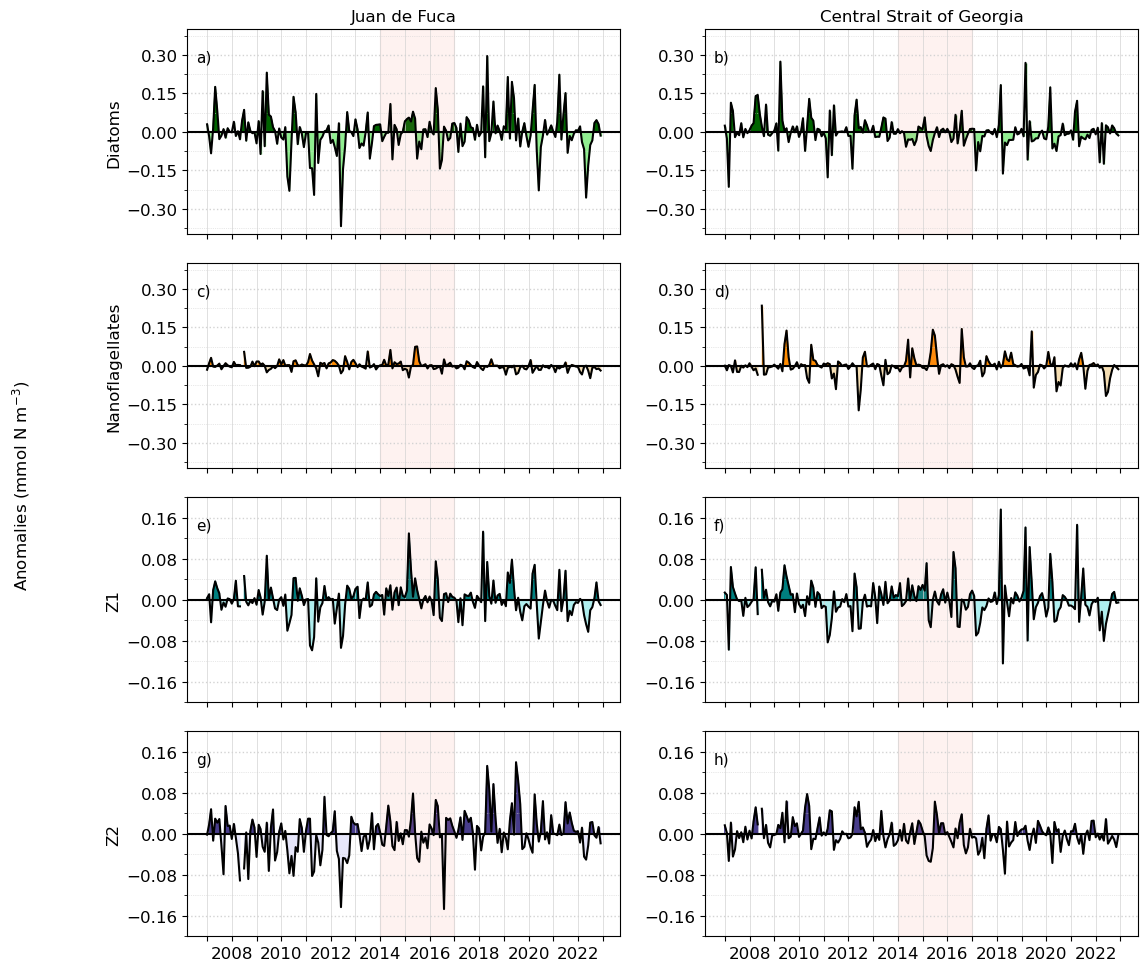

In [71]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator, MaxNLocator

fig, axes = plt.subplots(4, 2, figsize=(12, 10), sharex=True, sharey=False)

x = pd.date_range(start='2007-01', end='2022-12', freq='MS')

mean_anomalies_surf_list = [
    [JdF_diatom_anom, CSOG_diatom_anom],
    [JdF_flag_anom, CSOG_flag_anom],
    [JdF_Z1_anom, CSOG_Z1_anom],
    [JdF_Z2_anom, CSOG_Z2_anom]
]

variable_titles = ['Diatoms', 'Nanoflagellates', 'Z1', 'Z2']
region_titles = ['Juan de Fuca', 'Central Strait of Georgia']
labels = [['a)', 'b)'], ['c)', 'd)'], ['e)', 'f)'], ['g)', 'h)']]

for i in range(4):
    for j in range(2):
        ax = axes[i, j]
        y = mean_anomalies_surf_list[i][j]

        ax.plot(x, y, color='k')
        if i < 2:
            ax.set_ylim(-0.4, 0.4)
        else:
            ax.set_ylim(-0.2, 0.2)
        ax.axhline(y=0, color='k', linestyle='-')

        # Set y major and minor ticks
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(axis='y', labelsize=12)

        # Vertical gridlines (x), Horizontal gridlines (y); both major and minor
        ax.xaxis.set_major_locator(mdates.YearLocator(1))
        ax.grid(axis='y', which='major', linestyle=':', linewidth=1, color='lightgrey')
        ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5, color='lightgrey')
        ax.grid(axis='x', which='major', linestyle='-', linewidth=0.5, color='lightgrey')
        ax.grid(axis='x', which='minor', linestyle=':', linewidth=0.5, color='lightgrey')

        # Hide x-axis labels for all but bottom row
        if i < 3:
            ax.tick_params(labelbottom=False)
        else:
            # Ticks for every year
            ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Show every year
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            # Custom label formatter: only label even years
            ax.xaxis.set_major_formatter(
                ticker.FuncFormatter(lambda x, pos: f"{mdates.num2date(x).year}" if mdates.num2date(x).year % 2 == 0 else "")
            )
            ax.tick_params(axis='x', labelsize=12)

        # Fill colors
        if variable_titles[i] == 'Diatoms':
            ax.fill_between(x, y, where=(y > 0), color='darkgreen')
            ax.fill_between(x, y, where=(y < 0), color='lightgreen')
        elif variable_titles[i] == 'Nanoflagellates':
            ax.fill_between(x, y, where=(y > 0), color='darkorange')
            ax.fill_between(x, y, where=(y < 0), color='wheat')
        elif variable_titles[i] == 'Z1':
            ax.fill_between(x, y, where=(y > 0), color='teal')
            ax.fill_between(x, y, where=(y < 0), color='paleturquoise')
        else:
            ax.fill_between(x, y, where=(y > 0), color='darkslateblue')
            ax.fill_between(x, y, where=(y < 0), color='lavender')

        ax.text(0.02, 0.9, labels[i][j], transform=ax.transAxes, fontsize=11, va='top')

        if i == 0:
            ax.set_title(region_titles[j], fontsize=12)
        if j == 0:
            ax.set_ylabel(variable_titles[i], fontsize=12)

        # NEP-MHW highlight
        a = x[84]
        b = x[120]
        ax.fill_between([a, b], -10, 10, color='salmon', alpha=0.1)

# Shared y-axis label
fig.text(0.04, 0.5, 'Anomalies (mmol N m$^{-3}$)', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.1, 0, 1, 1])
plt.show()


## Plots for Supplemental Figures S5 and S6

In [60]:
JdF_diatom_surf = surface_biomass(JdF_diatoms_mean, e3t_JdF_mean)
JdF_flag_surf = surface_biomass(JdF_flag_mean, e3t_JdF_mean)
JdF_Z1_surf = surface_biomass(JdF_Z1_mean, e3t_JdF_mean)
JdF_Z2_surf = surface_biomass(JdF_Z2_mean, e3t_JdF_mean)

CSOG_diatom_surf = surface_biomass(CSOG_diatoms_mean, e3t_CSOG_mean)
CSOG_flag_surf = surface_biomass(CSOG_flag_mean, e3t_CSOG_mean)
CSOG_Z1_surf = surface_biomass(CSOG_Z1_mean, e3t_CSOG_mean)
CSOG_Z2_surf = surface_biomass(CSOG_Z2_mean, e3t_CSOG_mean)


JdFclim_diatom_surf = surface_biomass(JdFclim_diatoms, e3t_JdF_mean)
JdFclim_flag_surf = surface_biomass(JdFclim_flag, e3t_JdF_mean)
JdFclim_Z1_surf = surface_biomass(JdFclim_Z1, e3t_JdF_mean)
JdFclim_Z2_surf = surface_biomass(JdFclim_Z2, e3t_JdF_mean)

CSOGclim_diatom_surf = surface_biomass(CSOGclim_diatoms, e3t_CSOG_mean)
CSOGclim_flag_surf = surface_biomass(CSOGclim_flag, e3t_CSOG_mean)
CSOGclim_Z1_surf = surface_biomass(CSOGclim_Z1, e3t_CSOG_mean)
CSOGclim_Z2_surf = surface_biomass(CSOGclim_Z2, e3t_CSOG_mean)

/tmp/ipykernel_2566500/816431155.py:17: RuntimeWarning: invalid value encountered in divide
  biomass_surf = np.where(thickness_sum != 0, weighted_sum / thickness_sum, np.nan)


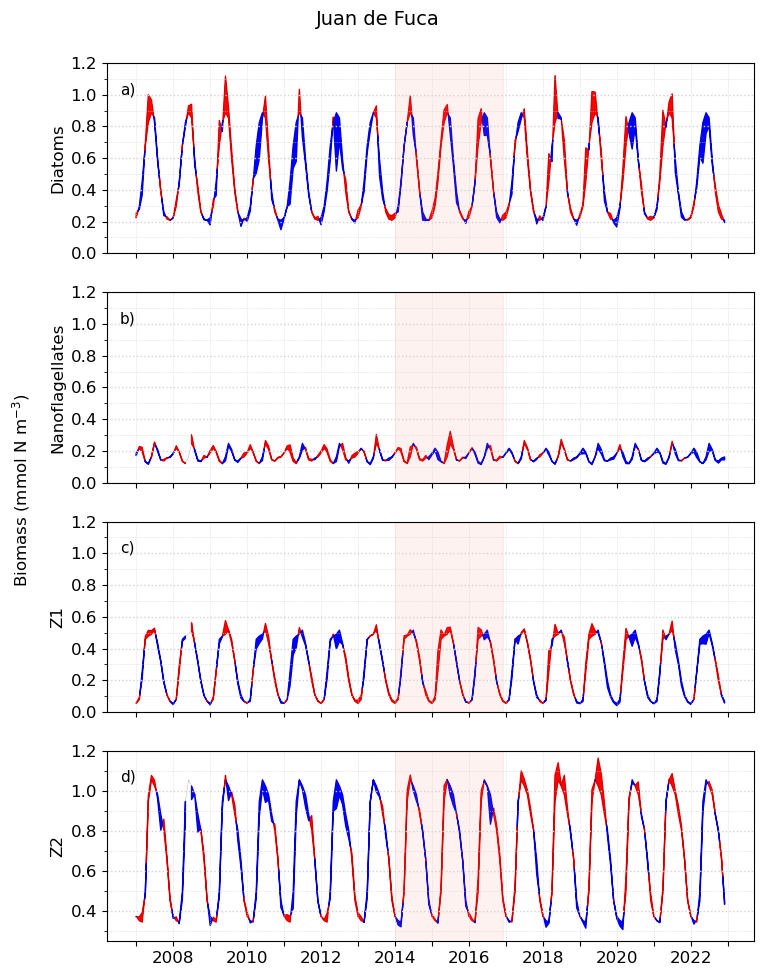

In [61]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator, MaxNLocator

x = pd.date_range(start='2007-01', end='2022-12', freq='MS')

#variable_colors = ['darkgreen', 'darkorange', 'teal', 'darkslateblue']
variable_colors = ['k', 'k', 'k', 'k']
variable_titles = ['Diatoms', 'Nanoflagellates', 'Z1', 'Z2']
labels = ['a)', 'b)', 'c)', 'd)']

biomass_list = [JdF_diatom_surf, JdF_flag_surf, JdF_Z1_surf, JdF_Z2_surf]
climatology_list = [JdFclim_diatom_surf, JdFclim_flag_surf, JdFclim_Z1_surf, JdFclim_Z2_surf]

fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

for i in range(4):
    ax = axes[i]
    biomass = biomass_list[i]
    climatology = climatology_list[i]

    ax.plot(x, climatology, color='k', linestyle='-', linewidth=0.1, label='Climatology', zorder=1)
    ax.plot(x, biomass, color=variable_colors[i], linewidth=0.1, label='Biomass', zorder=1)

    ax.fill_between(x, biomass, climatology, where=(biomass > climatology),
                    interpolate=True, color='r', alpha=1, zorder=0)
    ax.fill_between(x, biomass, climatology, where=(biomass < climatology),
                    interpolate=True, color='b', alpha=1, zorder=0)

    if variable_titles[i] == 'Diatoms':
        ax.set_ylim(0, 1.2)
    elif variable_titles[i] == 'Nanoflagellates':
        ax.set_ylim(0, 1.2)
    elif variable_titles[i] == 'Z1':
        ax.set_ylim(0, 1.2)
    else:
        ax.set_ylim(0.25, 1.2)

    ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='y', labelsize=12)

    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.grid(axis='y', which='major', linestyle=':', linewidth=1, color='lightgrey')
    ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5, color='lightgrey')
    ax.grid(axis='x', which='major', linestyle=':', linewidth=0.5, color='lightgrey')
    ax.grid(axis='x', which='minor', linestyle=':', linewidth=0.5, color='lightgrey')

    if i < 3:
        ax.tick_params(labelbottom=False)
    else:
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x_val, pos: f"{mdates.num2date(x_val).year}"
                                 if mdates.num2date(x_val).year % 2 == 0 else "")
        )
        ax.tick_params(axis='x', labelsize=12)

    ax.text(0.02, 0.9, labels[i], transform=ax.transAxes, fontsize=11, va='top')
    ax.set_ylabel(variable_titles[i], fontsize=12)

    a, b = x[84], x[119]
    ax.fill_between([a, b], -10, 10, color='salmon', alpha=0.1)

fig.suptitle('Juan de Fuca', fontsize=14)
fig.text(0.04, 0.5, 'Biomass (mmol N m$^{-3}$)', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.06, 0, 1, 1])
#plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.show()

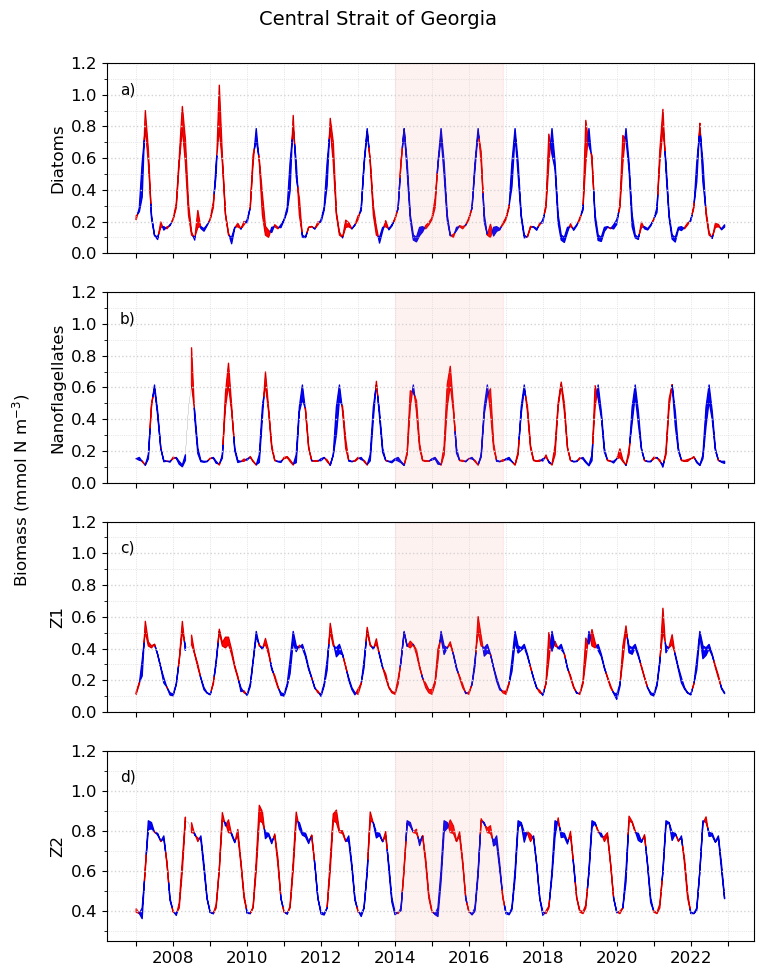

In [62]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator, MaxNLocator

x = pd.date_range(start='2007-01', end='2022-12', freq='MS')

#variable_colors = ['darkgreen', 'darkorange', 'teal', 'darkslateblue']
variable_colors = ['k', 'k', 'k', 'k']
variable_titles = ['Diatoms', 'Nanoflagellates', 'Z1', 'Z2']
labels = ['a)', 'b)', 'c)', 'd)']

biomass_list = [CSOG_diatom_surf, CSOG_flag_surf, CSOG_Z1_surf, CSOG_Z2_surf]
climatology_list = [CSOGclim_diatom_surf, CSOGclim_flag_surf, CSOGclim_Z1_surf, CSOGclim_Z2_surf]

fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

for i in range(4):
    ax = axes[i]
    biomass = biomass_list[i]
    climatology = climatology_list[i]

    ax.plot(x, climatology, color='k', linestyle='-', linewidth=0.1, label='Climatology', zorder=1)
    ax.plot(x, biomass, color=variable_colors[i], linewidth=0.1, label='Biomass', zorder=1)

    ax.fill_between(x, biomass, climatology, where=(biomass > climatology),
                    interpolate=True, color='r', alpha=1, zorder=0)
    ax.fill_between(x, biomass, climatology, where=(biomass < climatology),
                    interpolate=True, color='b', alpha=1, zorder=0)

    if variable_titles[i] == 'Diatoms':
        ax.set_ylim(0, 1.2)
    elif variable_titles[i] == 'Nanoflagellates':
        ax.set_ylim(0, 1.2)
    elif variable_titles[i] == 'Z1':
        ax.set_ylim(0, 1.2)
    else:
        ax.set_ylim(0.25, 1.2)

    ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='y', labelsize=12)

    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.grid(axis='y', which='major', linestyle=':', linewidth=1, color='lightgrey',zorder=0)
    ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5, color='lightgrey',zorder=0)
    ax.grid(axis='x', which='major', linestyle=':', linewidth=0.5, color='lightgrey',zorder=0)
    ax.grid(axis='x', which='minor', linestyle=':', linewidth=0.5, color='lightgrey',zorder=0)

    if i < 3:
        ax.tick_params(labelbottom=False)
    else:
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x_val, pos: f"{mdates.num2date(x_val).year}"
                                 if mdates.num2date(x_val).year % 2 == 0 else "")
        )
        ax.tick_params(axis='x', labelsize=12)

    ax.text(0.02, 0.9, labels[i], transform=ax.transAxes, fontsize=11, va='top')
    ax.set_ylabel(variable_titles[i], fontsize=12)

    a, b = x[84], x[119]
    ax.fill_between([a, b], -10, 10, color='salmon', alpha=0.1)

fig.suptitle('Central Strait of Georgia', fontsize=14)
fig.text(0.04, 0.5, 'Biomass (mmol N m$^{-3}$)', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.06, 0, 1, 1])
#plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.show()

In [63]:
JdFfiles.close()
Harofiles.close()
Pugetfiles.close()
CSOGfiles.close()
NSOGfiles.close()

In [64]:
# Use this cell to calculate maximum plankton anomalies for different time periods or regions
mask = (x >= np.datetime64('2015-01-01')) & (x <= np.datetime64('2015-12-31'))

# Apply the mask to get anomalies in that date range
anomaly_window = JdF_flag_anom[mask]

# Find the maximum anomaly value in that window
max_anomaly = np.nanmax(anomaly_window)

#print(f'Maximum anomaly (2009–2010): {max_anomaly:.2f} °C')

In [65]:
max_anomaly

0.07557849112159792

In [66]:
print(JdFclim_flag.mean())

0.16942731060825322


In [67]:
Percent=max_anomaly/JdFclim_flag.mean()
print(Percent*100)

44.60821035892445
